# Задание №4

Требуется написать SVM без библиотек, посчитать у него (разумеется) f-меру и confusion матрицу. Далее требуется разобраться в том, что такое критерий Вилкоксона, и сравнить с его помощью работу алгоритмов kNN и свежепосчитанный SVM, посчитать p-value. Всё это на старом наборе данных chips.txt из первой лабы. Уметь отвечать на любую теорию, как про SVM, так и про статистический тест.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

import numpy as np
import scipy as sp
from scipy import stats as sps
import scipy.optimize as spo

import math
from collections import namedtuple
from functools import partial

eps = 1e-8

# Работа с данными
## Считываем данные

In [2]:
data = pd.read_csv("chips.txt", header = None)

X = data.values[:,:2]
X[:, 0] = X[:, 0]
Y = data.values[:,2]

## Разделим на части для кросвалидации

In [3]:
np.random.seed(0)
block_n = 10
permutation = np.random.permutation(len(X))

x_parts = np.array_split(X[permutation], block_n)
y_parts = np.array_split(Y[permutation], block_n)

# Реализуем k nearest neighbors

In [4]:
class knnClassifier():
    def __init__(self, params):
        self.params = params
        
    def fit(self, x, y):
        self.x = self.params.trans(x)
        self.y = y
        
    def predict(self, points):
        points = self.params.trans(points)
        ans = []
        for point in points:
            distances = self.params.norm(self.x - point, axis = -1)
            dist_arg_sorted = np.argsort(distances)
            norm_distance = distances[dist_arg_sorted[self.params.k + 1]]

            ys = np.unique(self.y)
            scores = [np.sum(self.params.kernel(distances / norm_distance) * (self.y == y))
                      for y in ys]
            ans.append(ys[np.argmax(scores)])
        return np.array(ans)

#  Реализуем различные меры

In [5]:
def safeDiv(a, b):
    if (b == 0):
        return 0
    return a / b

In [6]:
def precision(contingency_table):
    return safeDiv(contingency_table[1][1], (contingency_table[1][1] + contingency_table[0][1]))

def recall(contingency_table):
    return safeDiv(contingency_table[1][1], (contingency_table[1][1] + contingency_table[0][0]))

In [7]:
def f1_measure(contingency_table):
    p = precision(contingency_table)
    r = recall(contingency_table)
    return safeDiv(2 * p * r, (p + r))

def f1_measure_reversed(contingency_table):
    ct = np.array(contingency_table)
    for i in [0, 1]:
        ct[i][0], ct[i][1] = ct[i][1], ct[i][0]
    return f1_measure(ct)

f1_measure_vec = np.vectorize(f1_measure, signature="(2,2)->()")
f1_measure_reversed_vec = np.vectorize(f1_measure_reversed, signature="(2,2)->()")

## Кросвалидация

In [8]:
def cross_validate_vec(x_parts, y_parts, classifier, cl=1):
    cts = []
    for i in range(len(x_parts)):
        x_train = np.concatenate(np.delete(x_parts, i, 0))
        y_train = np.concatenate(np.delete(y_parts, i, 0))
        x_test = x_parts[i]
        y_test = y_parts[i]
        
        classifier.fit(x_train, y_train)
        y_pred = classifier.predict(x_test)

        true_positive  = np.sum(np.logical_and(y_pred == cl, y_test == cl))
        false_positive = np.sum(np.logical_and(y_pred == cl, y_test != cl))
        true_negative  = np.sum(np.logical_and(y_pred != cl, y_test != cl))
        false_negative = np.sum(np.logical_and(y_pred != cl, y_test == cl))

        contingency_table = [[0, 0], [0, 0]]
        contingency_table[1][1] = true_positive  / y_test.shape[0]
        contingency_table[0][1] = false_positive / y_test.shape[0]
        contingency_table[1][0] = true_negative  / y_test.shape[0]
        contingency_table[0][0] = false_negative / y_test.shape[0]
        cts.append(contingency_table)
    
    return np.array(cts)

def cross_validate(x_parts, y_parts, classifier, cl=1):
    return np.average(cross_validate_vec(x_parts, y_parts, classifier, cl), axis = 0)

In [9]:
Params = namedtuple("Params", "k norm trans kernel")

def identity(x):
    return x

def withRadius(x):
    x = x - np.average(x, axis = 0)
    return np.column_stack([
        x[:,0],
        x[:,1],
        np.sqrt(x[:,0] ** 2 + x[:,1] ** 2)
    ])

def withSqr(x):
    x = x - np.average(x, axis = 0)
    return np.column_stack([
        x[:,0],
        x[:,1],
        x[:,0] ** 2,
        x[:,1] ** 2,
        x[:,0] * x[:,1]
    ])

def with3(x):
    x = x - np.average(x, axis = 0)
    return np.column_stack([
        x[:,0],
        x[:,1],
        x[:,0] ** 3,
        x[:,0] ** 2 * x[:,1],
        x[:,0] * x[:,1] ** 2,
        x[:,1] ** 3
    ])


## Реализуем различные ядра

In [10]:
def kernelConst(x):
    return (np.abs(x) < 1.0) * 0.5

def kernelTriangle(x):
    xabs = np.abs(x)
    return (xabs < 1.0) * (1.0 - xabs)

def kernelEpanechnikov(x):
    return 0.75 * (1.0 - x ** 2.0) * (np.abs(x) < 1.0)


knn_params = [
    Params(k, partial(np.linalg.norm, ord = norm_ord), trans_f, kernel_f)
    for k in np.arange(2, round(math.sqrt(len(X)) + 1))
    for norm_ord in [
        1,
        1.5,
        2
    ]
    for trans_f in [
        identity,
        withSqr,
        withRadius,
        with3
    ]
    # Parzen-Rosenblatt window with variable window width
    for kernel_f in [
        kernelConst,
        kernelTriangle,
        kernelEpanechnikov
    ]
]

In [11]:
knn_cts = [cross_validate(x_parts, y_parts, knnClassifier(p))
                     for p in knn_params]

In [12]:
knn_best_index = np.argmax([f1_measure(ct) for ct in knn_cts])
knn_best_param = knn_params[knn_best_index]
knn_best_ct    = knn_cts[knn_best_index]    

print(knn_best_param)

Params(k=11, norm=functools.partial(<function norm at 0x7ff238196730>, ord=1), trans=<function identity at 0x7ff203056950>, kernel=<function kernelTriangle at 0x7ff20308e7b8>)


# Отображение
## Настройка цвета

In [13]:
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])

## Настройка шага

In [14]:
step = 0.01
x_min, y_min = np.amin(X, axis = 0) - step
x_max, y_max = np.amax(X, axis = 0) + step

Классу передаются параметры метки и классификатор

Используется np.meshgrid: 
https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.meshgrid.html
Make N-D coordinate arrays for vectorized evaluations of N-D scalar/vector fields over N-D grids, given one-dimensional coordinate arrays x1, x2,..., xn.

Отображжаем с помощью функиции plt.pcolormesh:
https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.pcolormesh.html
Plot a quadrilateral mesh.

In [15]:
class Demonstrator():
    
    def __init__(self, x_min, y_min, x_max, y_max, step, classifier):
        self.x_min = x_min
        self.y_min = y_min
        self.x_max = x_max
        self.y_max = y_max
        self.step = step
        self.classifier = classifier
        
    def prepare(self, x, y):
        self.x = x
        self.y = y
        xx, yy = np.meshgrid(np.arange(self.x_min, self.x_max, self.step),
                             np.arange(self.y_min, self.y_max, self.step))
        self.xx = xx
        self.yy = yy

        self.classifier.fit(x, y)
        points = np.column_stack([self.xx.reshape((-1)), self.yy.reshape((-1))])
        self.zz = np.array([self.classifier.predict([p]) for p in points]).reshape(xx.shape)

    def plot(self):
        plt.figure(figsize=(15, 15))
        plt.xlim(self.x_min, self.x_max)
        plt.ylim(self.y_min, self.y_max)

        x0, y0 = self.x[self.y == 0].T
        x1, y1 = self.x[self.y == 1].T

        plt.pcolormesh(self.xx, self.yy, self.zz, cmap = cmap_light)
        plt.scatter(x0, y0, marker = 'D', color = 'red',  s = 50)
        plt.scatter(x1, y1, marker = 'o', color = 'blue', s = 50)
        plt.show()

In [16]:
d = Demonstrator(x_min, y_min, x_max, y_max, step, knnClassifier(knn_best_param))
d.prepare(X, Y)

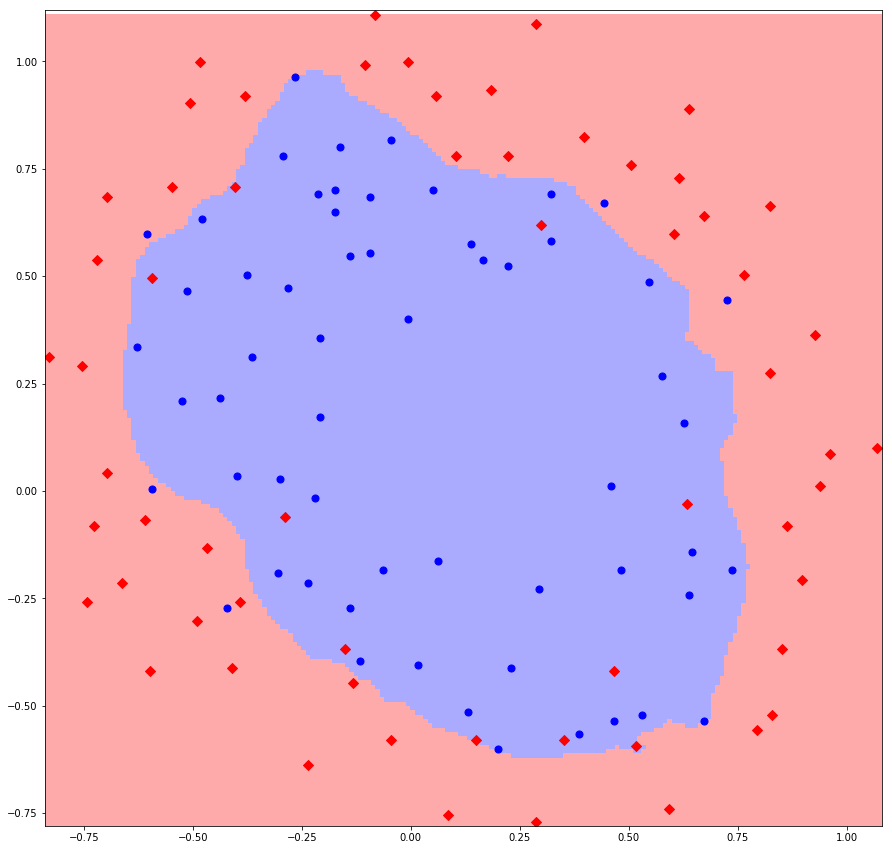

In [17]:
d.plot()

In [18]:
class svnClassifier():
    
    def __init__(self, kernel, c):
        self.kernel = kernel
        self.c = c
    
    def kernel_vec(self, point):
        return np.apply_along_axis(lambda x_i: self.kernel(x_i, point), 1, self.x)
    
    def fit(self, x, y):
        l = len(x)
        y = y * 2 - 1
        
        q_generator = lambda i, j : y[i] * y[j] * self.kernel(x[i], x[j])
        q = np.fromfunction(np.vectorize(q_generator), (l, l), dtype=int)
        l_ones = np.ones(l)

        L = lambda x : x.dot(q).dot(x) / 2 - np.dot(l_ones, x)
        constr = [ { "type": "eq",   "fun": lambda x: np.dot(y, x)        }
                 , { "type": "ineq", "fun": lambda x: x                   }
                 , { "type": "ineq", "fun": lambda x: self.c * l_ones - x } ]

        opt = spo.minimize(L, np.random.randn(l), constraints = constr)
        
        self.l_y = opt.x * y
        self.x   = x
        
        support_indices = np.nonzero(np.logical_and(opt.x > eps, opt.x < self.c - eps))[0]
        self.w_0 = 0
        if (len(support_indices) > 0):
            sv_index = support_indices[0]
            self.w_0 = np.dot(self.l_y, self.kernel_vec(x[sv_index])) - y[sv_index]
        
    def predict(self, points):
        ans = []
        for point in points:
            ans.append((np.sign(np.dot(self.l_y, self.kernel_vec(point)) - self.w_0) + 1) / 2)
        return np.array(ans, dtype = np.int)

In [19]:
def expKern(x, y):
    return 2.7182818284590452354 ** (- (np.linalg.norm(x - y) ** 2) / 2)

def poly3(x, y):
    return (np.dot(x, y) + 1) ** 3

def wikiKern(x, y):
    return np.dot(x, y)  + (np.linalg.norm(x) ** 2) * (np.linalg.norm(y) ** 2)

svn_params = [(kern, c)
              for kern in [
                  expKern, 
                  poly3,
              ]
              for c in [
                  5,
                  8,
                  10,
              ]
             ]

In [20]:
svn_cts = [cross_validate(x_parts, y_parts, svnClassifier(kern, c))
           for kern, c in svn_params]

In [21]:
svn_best_index = np.argmax([f1_measure_reversed(ct) for ct in svn_cts])
svn_best_param = svn_params[svn_best_index]
svn_best_ct    = svn_cts[svn_best_index]    

print(svn_best_param)
print(svn_cts)

(<function expKern at 0x7ff203056268>, 8)
[array([[ 0.07651515,  0.10378788],
       [ 0.40681818,  0.41287879]]), array([[ 0.05909091,  0.11212121],
       [ 0.39848485,  0.43030303]]), array([[ 0.05909091,  0.11212121],
       [ 0.39848485,  0.43030303]]), array([[ 0.05909091,  0.12045455],
       [ 0.39015152,  0.43030303]]), array([[ 0.05909091,  0.11212121],
       [ 0.39848485,  0.43030303]]), array([[ 0.05909091,  0.11212121],
       [ 0.39848485,  0.43030303]])]


In [22]:
print(cross_validate(x_parts, y_parts, knnClassifier(knn_best_param)))
print(cross_validate(x_parts, y_parts, svnClassifier(svn_best_param[0], svn_best_param[1])))

[[ 0.08409091  0.11212121]
 [ 0.39848485  0.40530303]]
[[ 0.05909091  0.11212121]
 [ 0.39848485  0.43030303]]


In [23]:
k = 2
d = Demonstrator(x_min * k, y_min * k, x_max * k, y_max * k, step * k * 2, svnClassifier(*svn_best_param))
d.prepare(X, Y)

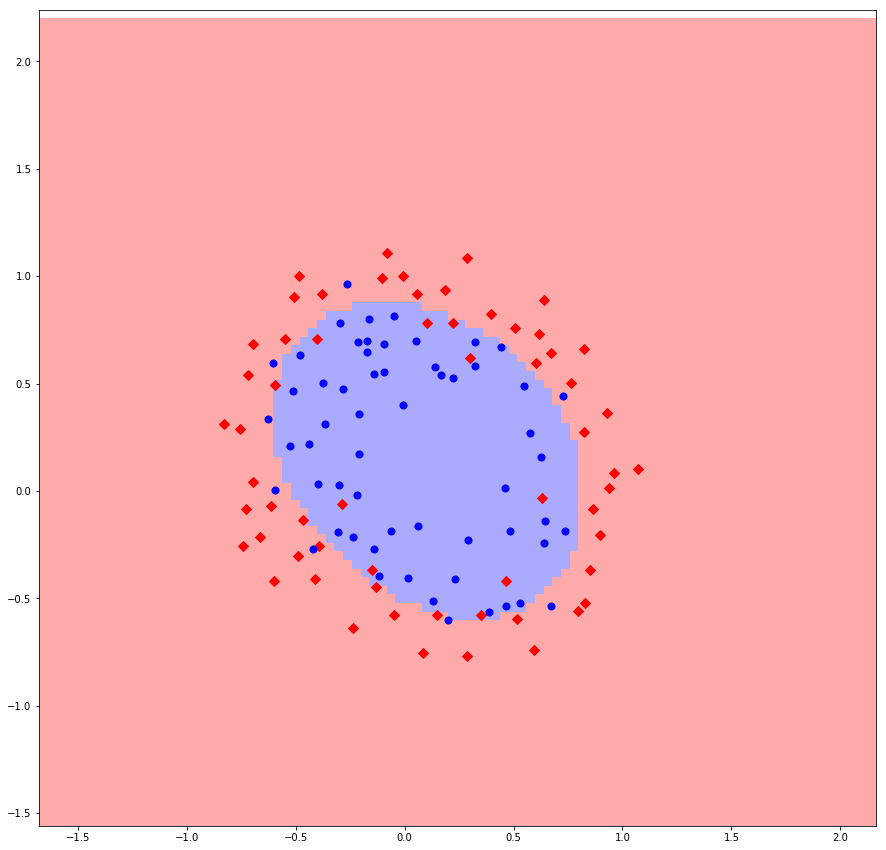

In [24]:
d.plot()

# Тест Вилкоксона

Посчитаем fi measure для всех векторов слов посчитанных с помощью rnn и svm 

In [25]:
knn_f1_vec = f1_measure_vec(cross_validate_vec(x_parts, y_parts, knnClassifier(knn_best_param)))
svn_f1_vec = f1_measure_vec(cross_validate_vec(x_parts, y_parts, svnClassifier(svn_best_param[0], svn_best_param[1])))

In [26]:
def wilcoxon(x, y):
    d = x - y
    d = np.compress(np.not_equal(d, 0), d, axis=-1)
    n = len(d)
    r = sps.rankdata(np.abs(d))
    r_plus = np.sum((d > 0) * r, axis=0)
    r_minus = np.sum((d < 0) * r, axis=0)
    T = min(r_plus, r_minus)
    
    mu  = n * (n + 1) / 4
    std = np.sqrt(n * (n + 1) * (2 * n + 1) / 24)
    z   = (T - mu) / std
    
    return (T, 1 - sp.special.erf(abs(z)))

In [27]:
T = wilcoxon(knn_f1_vec, svn_f1_vec)
print(T)

(1.0, 0.013175029697879093)
